<a href="https://colab.research.google.com/github/Qvery-mm/NumericMethods_3/blob/main/6_term_lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вычислительный практикум, 6 семестр
# Задание №3
# Численное решение интегрального уравнения Фредгольма второго рода
### Ковальчуков Александр
### 321 группа
### Вариант №6

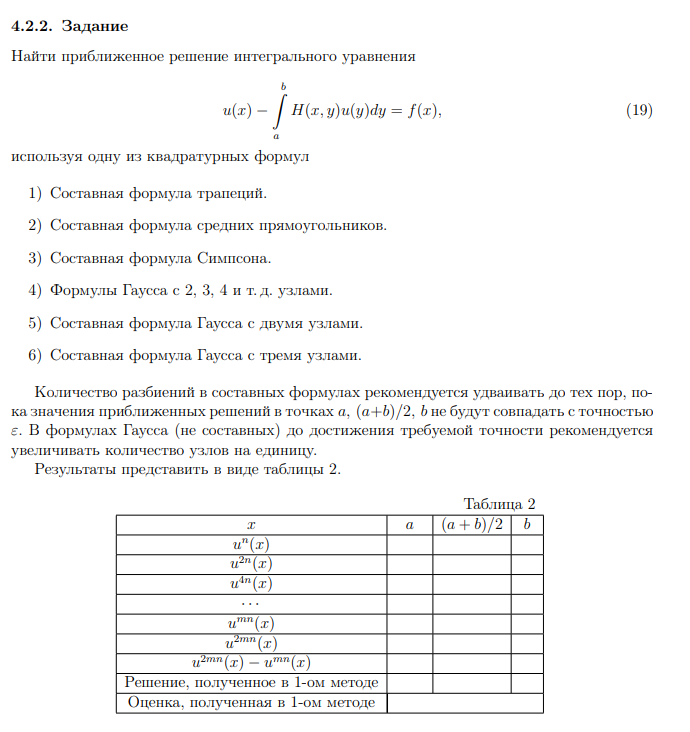

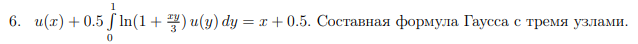

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import jacobi
from math import *

In [2]:
def H(x, y): return -0.5 * log(1 + x*y/3)
def f(x): return x + 0.5
a = 0
b = 1

In [3]:
def jacobix(k, n, x):
  '''
  Функция возвращает массив значений в точке x полиномов Якоби p(i),
  i=0,1,...,n, i - степень полинома, k - верхний индекс.
  '''
  return np.array([jacobi(n=j, alpha=k, beta=k)(x) for j in range(n+1)])
  

In [4]:
def nodes_coeff_Gauss_Newton(n, eps):
    '''
    Функция возвращает узлы и коэффициенты формулы Гаусса.
    n - количество узлов.
    eps - точность вычисления узлов.
    Узлы находятся по методу Ньютона.
    '''
    xg = [0] * n
    Ag = [0] * n
    for i in range(n):
        x0 = -cos((i+1 - 0.25) / (n + 0.5) * pi)
        dif = 2 * eps
        k = 0
        while abs(dif) > eps:
            ar_p = jacobix(0, n, x0) # Массив многочленов Лежандра P0(x0), P1(x0),...,Pn(x0)
            ar_dp = (n + 1) / 2 * jacobix(1, n-1, x0) #Массив P0’(x0), P1(x0)’,...,Pn’(x0)
            dif = ar_p[n] / ar_dp[n-1];
            x0 = x0 - dif;
            k = k + 1;
        xg[i] = x0;
    for i in range(n):
        tmp = jacobix(1, n-1, xg[i]);
        Ag[i] = 2 / ( (1 - xg[i]**2) * ((n + 1) / 2 * tmp[n-1])**2);

    return xg, Ag


In [5]:
eps = 1e-6 
p = 3 # количество узлов в квадратурной формуле Гаусса
gauss_nodes, gauss_coefs = nodes_coeff_Gauss_Newton(p, eps)

Для составной квадратурной формулы Гаусса с 3 узлами, узлы и коэффициенты будут следующими:

In [21]:
print('Количество узлов:', p)
print('Узлы:', gauss_nodes)
print('Коэффициенты:', gauss_coefs)

Количество узлов: 3
Узлы: [-0.7745966692414842, -6.123233995736766e-17, 0.7745966692414841]
Коэффициенты: [0.5555555555555527, 0.8888888888888888, 0.5555555555555541]


In [6]:
def integrate(f, a, b, m):
  h = (b - a) / m
  return sum([h/2 * gauss_coefs[j % p] * f(h/2 * gauss_nodes[j] + a + (2 * i + 1)* h / 2)for i in range(m) for j in range(p)])

In [7]:
def get_nodes_coefs(a, b, m):
  h = (b - a) / m
  nodes = [h/2 * gauss_nodes[j] + a + (2 * i + 1)* h / 2 for i in range(m) for j in range(p)]
  coefs = [h/2 * gauss_coefs[j % p] for i in range(m) for j in range(p)]
  return nodes, coefs

In [8]:
def delta(i, j): return i == j

В качестве начального приближения можно взять нулевое решение.


In [9]:
def u_0(x): return 0

Выберем начальное количество разбиений и требуемую точность


In [10]:
n = 2
eps = 1e-6
stop = False
history = pd.DataFrame(columns=['x', 'a', '(a+b)/2', 'b'])

In [11]:
while not stop:
  nodes, coefs = get_nodes_coefs(a, b, n)
  g = np.array(list(map(f, nodes)))
  # g.reshape((p * n, 1))
  D = np.zeros((p * n, p * n))
  for j in range(p * n):
    for k in range(p * n):
      D[j, k] = delta(j, k) - coefs[k] * H(nodes[j], nodes[k])
  z = np.linalg.solve(D, g)

  def u_n(x):
    return sum(coefs[i] * H(x, nodes[i]) * z[i] for i in range(p * n)) + f(x)
    
  row = {'x': f'u_{n}(x)' , 'a': u_n(a), '(a+b)/2': u_n((a+b)/2), 'b': u_n(b)}                            
  history = history.append(row, ignore_index=True)

  if abs(u_0(a) - u_n(a)) < eps and abs(u_0((a+b)/2) - u_n((a+b)/2)) < eps and abs(u_0(b) - u_n(b)) < eps:
    stop = True
  else:
    u_0 = u_n
    n += 1

row = {'x': f'u_{n}(x) - u_{n-1}(x)' , 'a': u_n(a) - u_0(a), '(a+b)/2': u_n((a+b)/2) - u_0((a+b)/2), 'b': u_n(b) - u_0(b)}                            
history = history.append(row, ignore_index=True)

In [12]:
history

,x,a,(a+b)/2,b
0,u_2(x),0.5,0.956287,1.416915
1,u_3(x),0.5,0.956287,1.416915
2,u_3(x) - u_2(x),0.0,0.000000,0.000000


Посмотрим на график решения и величину невязки

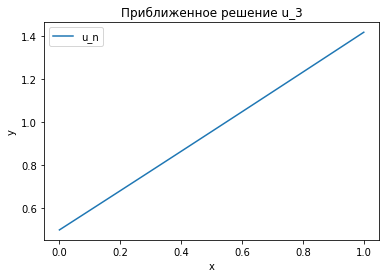

In [13]:
x = np.linspace(a, b, 100)
y = list(map(u_n, x))
plt.plot(x, y, label='u_n')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f'Приближенное решение u_{n}')
plt.show()

In [14]:
  def diff(x):
    def under_int(y): return H(x, y) * u_n(y)
    return u_n(x) - integrate(under_int, a, b, n) - f(x)

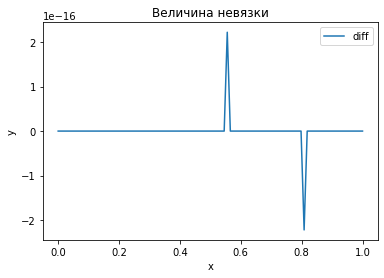

In [15]:
x = np.linspace(a, b, 100)
y = list(map(diff, x))
plt.plot(x, y, label='diff')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Величина невязки')
plt.show()

# Ответ

Приближённым решением задачи является функция 

In [16]:
print(f'u_{n}(x) = {round(u_n(b) - u_n(a) / (b - a), 4)}x + {u_n(a)}')

u_3(x) = 0.9169x + 0.5


Величина невязки при этом не превосходит

In [17]:
max(y)

2.220446049250313e-16